In [ ]:
# Manage warning messages

import os, warnings
warnings.filterwarnings('ignore')

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Download and preprocess stock data as described in 5.1

df = yf.download('JPM', start='1980-01-01', end='2024-01-01')
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')
df['Close'].interpolate(method='linear', inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Define the size of the training and testing set

train_size = int(len(df) * 0.8)
train_data = df['Close'][:train_size]
test_data = df['Close'][train_size:]


In [6]:
# train_data

In [7]:
# Detrending the time series

train_data_diff = train_data.diff().dropna()
test_data_diff = test_data.diff().dropna()

In [120]:
# Scale the data to the range [0, 1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(np.array(train_data_diff).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data_diff).reshape(-1, 1))


In [121]:
# Function to create sequences of data for RNN input

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [122]:
time_step = 3  # Number of time steps to look back


In [123]:
# Create training sequences

X_train, y_train = create_sequences(scaled_train, time_step)
X_test, y_test = create_sequences(np.concatenate((scaled_train[-time_step:], scaled_test)), time_step)

In [124]:
# Reshape the data for RNN input

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [125]:
# Build and compile the RNN model

model = Sequential()
model.add(SimpleRNN(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(100, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [126]:
# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0220 - val_loss: 0.0182
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0030 - val_loss: 0.0177
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0029 - val_loss: 0.0175
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0029 - val_loss: 0.0179
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0028 - val_loss: 0.0173
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0026 - val_loss: 0.0177
Epoch 7/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0026 - val_loss: 0.0175
Epoch 8/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0027 - val_loss: 0.0174
Epoch 9/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0025 - val_loss: 0.0172
Epoch 10/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0027 - val_loss: 0.0173
Epoch 11/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0027 - val_loss: 0.0173
Epoch 12/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

In [127]:
# Make predictions on the training and test data

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [128]:
# Inverse transform the predictions to the original scale

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [129]:
# Fetch the actual future stock prices for comparison

actual_future_df = yf.download('JPM', start='2024-01-02', end='2024-01-05')
actual_future_prices = actual_future_df['Close'].values


[*********************100%%**********************]  1 of 1 completed


In [130]:
next = 3  # Number of days to forecast

In [131]:
# Prepare the input for future predictions

future_inputs = df['Close'][-time_step:].values.reshape(1, time_step, 1)
future_predictions = []
for _ in range(next):
    future_pred = model.predict(future_inputs)
    future_predictions.append(future_pred[0, 0])
    future_inputs = np.append(future_inputs[:, 1:, :], future_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [132]:
# Invert the differencing for future predictions

last_value = df['Close'].iloc[-1]
future_predictions_orig = last_value + np.cumsum(future_predictions)

In [133]:
future_predictions_orig

array([169.86256, 170.86676, 172.97336], dtype=float32)

In [134]:
# Evaluate the predictions

future_rmse = np.sqrt(mean_squared_error(actual_future_prices, future_predictions_orig))
future_mape = mean_absolute_percentage_error(actual_future_prices, future_predictions_orig)

print(f'Root Mean Squared Error for RNN: {future_rmse}')
print(f'Mean Absolute Percentage Error for RNN: {future_mape}')

RMSE using RNN: 1.5890982952795663
MAPE using RNN: 0.008236813055486774


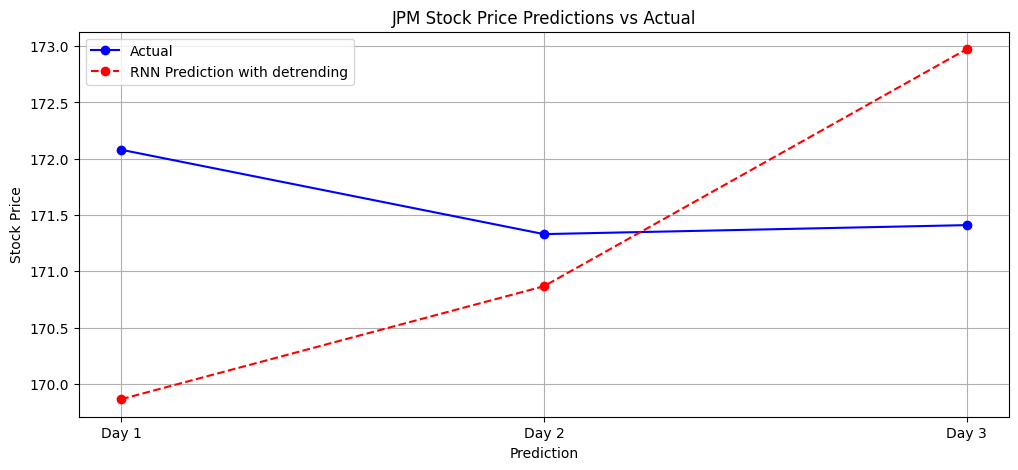

In [135]:
# Visualize the predictions as shown in Figure 4

days = ["Day 1", "Day 2", "Day 3"]
actual_new_cases = actual_future_df['Close'].values
predicted_new_cases = future_predictions_orig

plt.figure(figsize=(12, 5))
plt.plot(days, actual_new_cases, marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(days, predicted_new_cases, marker='o', linestyle='--', color='red', label='RNN Prediction with detrending')

plt.title('JPM Stock Price Predictions vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Stock Price')
plt.legend()

plt.grid(True)
plt.show()
